In [199]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [200]:
coarsenscale = 5
lccs_resolution = 300 * coarsenscale #m
areapergrid = (lccs_resolution/1000) ** 2 ## km2

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

mwpergrid_wind = np.round(areapergrid * mwperkm2_wind,2)
mwpergrid_solar =  np.round(areapergrid * mwperkm2_solar,2)

print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)


areapergrid =  2.25
mwpergrid_wind =  10.12
mwpergrid_solar =  33.75


In [201]:
xr_final_SI_raw = xr.open_dataset('Output\\xr_final_SI.nc')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('ADM1_EN')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGEC')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_Biomass')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_BGWW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_MSW')
xr_final_SI_raw = xr_final_SI_raw.drop_vars('A_IEW')
print(xr_final_SI_raw)

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 ...
    SI_Wind    (lat, lon) float64 ...
    AVA_Wind   (lat, lon) float32 ...
    AVA_Solar  (lat, lon) float32 ...


In [202]:
xr_final_SI = xr_final_SI_raw.coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').sum()
xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] / (coarsenscale**2)
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] / (coarsenscale**2)

######### Find min/max SI within cell #############
xr_final_SI['SI_Wind_max'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
xr_final_SI['SI_Wind_min'] = xr_final_SI_raw['SI_Wind'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()
xr_final_SI['SI_Solar_max'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').max()
xr_final_SI['SI_Solar_min'] = xr_final_SI_raw['SI_Solar'].coarsen(lat = coarsenscale, lon= coarsenscale, boundary='trim').min()


print(xr_final_SI.data_vars)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())


Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(78108.48, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(82200.78, dtype=float32)
Max SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.56912345)
Max SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2.71569582)


In [203]:
######### Next I assign Region to xarray ################################################################################

region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')

thailandmap.crs = {'init': 'epsg:4326'}
list_region = []

count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')       
    
thailandmap['region'] = list_region
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.set_geometry('center')

thailandmap = thailandmap.drop(columns=['Shape_Leng',
                                        'Shape_Area',
                                        'ADM1_PCODE',
                                        'ADM1_REF',
                                        'ADM1ALT1EN',
                                        'ADM1ALT2EN',
                                        'ADM1ALT1TH',
                                        'ADM1ALT2TH',
                                        'ADM0_EN',
                                        'ADM0_TH',
                                        'ADM0_PCODE',
                                        'date',
                                        'validOn',
                                        'validTo'
                                        ,'geometry'
                                        ])


print(thailandmap['ADM1_EN'].unique())
print(thailandmap['region'].unique())

['Bangkok' 'Samut Prakan' 'Nonthaburi' 'Pathum Thani'
 'Phra Nakhon Si Ayutthaya' 'Ang Thong' 'Lop Buri' 'Sing Buri' 'Chai Nat'
 'Saraburi' 'Chon Buri' 'Rayong' 'Chanthaburi' 'Trat' 'Chachoengsao'
 'Prachin Buri' 'Nakhon Nayok' 'Sa Kaeo' 'Nakhon Ratchasima' 'Buri Ram'
 'Surin' 'Si Sa Ket' 'Ubon Ratchathani' 'Yasothon' 'Chaiyaphum'
 'Amnat Charoen' 'Bueng Kan' 'Nong Bua Lam Phu' 'Khon Kaen' 'Udon Thani'
 'Loei' 'Nong Khai' 'Maha Sarakham' 'Roi Et' 'Kalasin' 'Sakon Nakhon'
 'Nakhon Phanom' 'Mukdahan' 'Chiang Mai' 'Lamphun' 'Lampang' 'Uttaradit'
 'Phrae' 'Nan' 'Phayao' 'Chiang Rai' 'Mae Hong Son' 'Nakhon Sawan'
 'Uthai Thani' 'Kamphaeng Phet' 'Tak' 'Sukhothai' 'Phitsanulok' 'Phichit'
 'Phetchabun' 'Ratchaburi' 'Kanchanaburi' 'Suphan Buri' 'Nakhon Pathom'
 'Samut Sakhon' 'Samut Songkhram' 'Phetchaburi' 'Prachuap Khiri Khan'
 'Nakhon Si Thammarat' 'Krabi' 'Phangnga' 'Phuket' 'Surat Thani' 'Ranong'
 'Chumphon' 'Songkhla' 'Satun' 'Trang' 'Phatthalung' 'Pattani' 'Yala'
 'Narathiwat']
['R0' 'R1

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_16484\1503556515.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid


In [204]:
df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI.reset_index(inplace= True, drop = False)
print(df_final_SI.columns)

df_final_SI_2 = gpd.sjoin_nearest(df_final_SI,thailandmap,how = 'left')
df_final_SI_2 = df_final_SI_2.drop(columns=['ADM1_TH','geometry','index_right'])

df_final_SI_2 = df_final_SI_2.drop_duplicates('index')
df_final_SI_2 = df_final_SI_2.drop(columns=['index'])

df_final_SI_2.reset_index(inplace= True, drop = True)
df_final_SI_2 = df_final_SI_2.set_index(['lat', 'lon'])
print(df_final_SI_2)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Index(['index', 'lat', 'lon', 'SI_Solar', 'SI_Wind', 'AVA_Wind', 'AVA_Solar',
       'SI_Wind_max', 'SI_Wind_min', 'SI_Solar_max', 'SI_Solar_min',
       'geometry'],
      dtype='object')
                      SI_Solar  SI_Wind  AVA_Wind  AVA_Solar  SI_Wind_max  \
lat       lon                                                               
5.620833  97.351389        0.0      0.0       0.0        0.0          0.0   
          97.365278        0.0      0.0       0.0        0.0          0.0   
          97.379167        0.0      0.0       0.0        0.0          0.0   
          97.393056        0.0      0.0       0.0        0.0          0.0   
          97.406944        0.0      0.0       0.0        0.0          0.0   
...                        ...      ...       ...        ...          ...   
20.454167 105.573611       0.0      0.0       0.0        0.0          0.0   
          105.587500       0.0      0.0       0.0        0.0          0.0   
          105.601389       0.0      0.0  

In [205]:
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI_2)
print(xr_final_SI)

<xarray.Dataset>
Dimensions:       (lat: 1069, lon: 597)
Coordinates:
  * lat           (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon           (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3'

In [206]:
print(xr_final_SI)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("max AVA Wind = ",xr_final_SI['AVA_Wind'].max())
print("max AVA Solar = ",xr_final_SI['AVA_Solar'].max())

print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())
print('Max SI Solar = ',xr_final_SI['SI_Solar'].max())

<xarray.Dataset>
Dimensions:       (lat: 1069, lon: 597)
Coordinates:
  * lat           (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon           (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3'

################################### NOW ITS AN OPTIMIZATION TIME !!!!!! ##############################################################################

In [207]:
## xr_ref = xr.open_dataset('Output\\xr_final_SI_preped.nc')
xr_ref = xr_final_SI
print("AVA Wind = ",xr_ref['AVA_Wind'].sum())
print("AVA Solar = ",xr_ref['AVA_Solar'].sum())
print('Mean SI Wind = ',xr_ref['SI_Wind'].where(xr_ref['SI_Wind']>0).mean())
print('Mean SI Solar = ',xr_ref['SI_Solar'].where(xr_ref['SI_Solar']>0).mean())
print('Max SI Wind = ',xr_ref['SI_Wind'].max())
print('Max SI Solar = ',xr_ref['SI_Solar'].max())
print('coarsenscale = ',coarsenscale)
print('areapergrid = ',areapergrid)
print('mwpergrid_wind = ',mwpergrid_wind)
print('mwpergrid_solar = ',mwpergrid_solar)

# ######## PDP ############################################################
# quota_wind_total =  0
# quota_wind_R0 = 0
# quota_wind_R1 = 0
# quota_wind_R2 = 0
# quota_wind_R3 =  0
# quota_wind_R4 =  0

# quota_solar_total =  0
# quota_solar_R0 =  0
# quota_solar_R1 =  0
# quota_solar_R2 =  0
# quota_solar_R3 = 0
# quota_solar_R4 =  0
# ######## PDP ############################################################

######## PDP ############################################################
quota_wind_total =  6335
quota_wind_R0 = 0
quota_wind_R1 = 0
quota_wind_R2 = 6075
quota_wind_R3 =  260
quota_wind_R4 =  0

quota_solar_total =  24182
quota_solar_R0 =  16
quota_solar_R1 =  4133
quota_solar_R2 =  4989
quota_solar_R3 = 8825
quota_solar_R4 =  6219
######## PDP ############################################################'

AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(78108.48, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(82200.78, dtype=float32)
Mean SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(0.60242001)
Mean SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(0.85858885)
Max SI Wind =  <xarray.DataArray 'SI_Wind' ()>
array(2.56912345)
Max SI Solar =  <xarray.DataArray 'SI_Solar' ()>
array(2.71569582)
coarsenscale =  5
areapergrid =  2.25
mwpergrid_wind =  10.12
mwpergrid_solar =  33.75


In [208]:
######################## model #####################################################
m = linopy.Model()

built_wind = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_wind')
cap_wind = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_wind')

built_solar = m.add_variables(integer=True,upper = 1,lower =0, coords=xr_ref.coords, name='built_solar')
cap_solar = m.add_variables(lower=0.00, coords=xr_ref.coords, name='cap_solar')


############################################ Constraint Building Location Logic ##############################################################################
constr_built_logic =  m.add_constraints(
    (
        built_wind
        +
        built_solar
    )
        <= 1
        , name='constr_built_logic'
)

############################################ Constraint Building Location Logic ##############################################################################

############################################ Constraint Capacity ##############################################################################
constr_maxcap_wind = m.add_constraints(
    cap_wind <= (built_wind) * xr_ref['AVA_Wind'] * mwperkm2_wind
    ,name = 'constr_maxcap_wind'
)
constr_mincap_wind = m.add_constraints(
    cap_wind >= (built_wind) * 1
    ,name = 'constr_mincap_wind'
)

constr_maxcap_solar = m.add_constraints(
    cap_solar <= (built_solar) * xr_ref['AVA_Solar'] * mwperkm2_solar
    ,name = 'constr_maxcap_solar'
)
constr_mincap_solar = m.add_constraints(
    cap_solar >= (built_solar) * 1
    ,name = 'constr_mincap_solar'
)
############################################ Constraint Capacity ##############################################################################

###########################################################################################################################################################

constr_quota_wind = m.add_constraints((cap_wind.where(xr_ref['SI_Wind'] >= 0.1,drop=True).sum()) >= quota_wind_total , name='constr_quota_wind')

constr_quota_wind_r0 = m.add_constraints(lhs = (cap_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_wind_R0, name='constr_quota_wind_r0')

constr_quota_wind_r1 = m.add_constraints(lhs = (cap_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_wind_R1, name='constr_quota_wind_r1')

constr_quota_wind_r2 = m.add_constraints(lhs = (cap_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_wind_R2, name='constr_quota_wind_r2')

constr_quota_wind_r3 = m.add_constraints(lhs = (cap_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_wind_R3, name='constr_quota_wind_r3')

constr_quota_wind_r4 = m.add_constraints(lhs = (cap_wind).where((xr_ref['SI_Wind'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_wind_R4, name='constr_quota_wind_r4')

############################################################################################################################################################

constr_quota_solar = m.add_constraints((cap_solar.where(xr_ref['SI_Solar'] >= 0.1,drop=True).sum()) >= quota_solar_total, name='constr_quota_solar')

constr_quota_solar_r0 = m.add_constraints(lhs = (cap_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R0'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_solar_R0, name='constr_quota_solar_r0')

constr_quota_solar_r1 = m.add_constraints(lhs = (cap_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R1'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_solar_R1, name='constr_quota_solar_r1')

constr_quota_solar_r2 = m.add_constraints(lhs = (cap_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R2'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_solar_R2, name='constr_quota_solar_r2')

constr_quota_solar_r3 = m.add_constraints(lhs = (cap_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R3'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_solar_R3, name='constr_quota_solar_r3')

constr_quota_solar_r4 = m.add_constraints(lhs = (cap_solar).where((xr_ref['SI_Solar'] >= 0.1) & (xr_ref['region'] == 'R4'),drop=True).sum()
                                             , sign = '>=' , rhs = quota_solar_R4, name='constr_quota_solar_r4')

###########################################################################################################################################################

In [209]:
obj = (-1000) * (

    ( xr_ref['SI_Wind'] * (cap_wind) / (mwpergrid_wind) )
    +
    ( xr_ref['SI_Solar'] * (cap_solar) / (mwpergrid_solar) )
)

m.add_objective(obj)

In [210]:
print("presolve = ",m)
m.solve(solver_name='highs',
        # mip_abs_gap = 0.002,
        # mip_rel_gap = 0.002,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)
print(solution)

presolve =  Linopy MILP model

Variables:
----------
 * built_wind (lat, lon)
 * cap_wind (lat, lon)
 * built_solar (lat, lon)
 * cap_solar (lat, lon)

Constraints:
------------
 * constr_built_logic (lat, lon)
 * constr_maxcap_wind (lat, lon)
 * constr_mincap_wind (lat, lon)
 * constr_maxcap_solar (lat, lon)
 * constr_mincap_solar (lat, lon)
 * constr_quota_wind
 * constr_quota_wind_r0
 * constr_quota_wind_r1
 * constr_quota_wind_r2
 * constr_quota_wind_r3
 * constr_quota_wind_r4
 * constr_quota_solar
 * constr_quota_solar_r0
 * constr_quota_solar_r1
 * constr_quota_solar_r2
 * constr_quota_solar_r3
 * constr_quota_solar_r4

Status:
-------
initialized


Writing integer variables.: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


aftersolve =  Linopy MILP model

Variables:
----------
 * built_wind (lat, lon)
 * cap_wind (lat, lon)
 * built_solar (lat, lon)
 * cap_solar (lat, lon)

Constraints:
------------
 * constr_built_logic (lat, lon)
 * constr_maxcap_wind (lat, lon)
 * constr_mincap_wind (lat, lon)
 * constr_maxcap_solar (lat, lon)
 * constr_mincap_solar (lat, lon)
 * constr_quota_wind
 * constr_quota_wind_r0
 * constr_quota_wind_r1
 * constr_quota_wind_r2
 * constr_quota_wind_r3
 * constr_quota_wind_r4
 * constr_quota_solar
 * constr_quota_solar_r0
 * constr_quota_solar_r1
 * constr_quota_solar_r2
 * constr_quota_solar_r3
 * constr_quota_solar_r4

Status:
-------
ok
<xarray.Dataset>
Dimensions:      (lat: 1069, lon: 597)
Coordinates:
  * lat          (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon          (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    built_wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cap_wind     (lat, lon

In [211]:
xr_ref['cap_wind'] = solution['cap_wind'] * solution['built_wind']
xr_ref['cap_solar'] = solution['cap_solar'] * solution['built_solar']

print("cap_wind = ",xr_ref['cap_wind'].sum())
print("cap_solar = ",xr_ref['cap_solar'].sum())
print(xr_ref.data_vars)
xr_ref.to_netcdf(path='Output\\xr_output.nc')

cap_wind =  <xarray.DataArray 'cap_wind' ()>
array(30123.49574599)
cap_solar =  <xarray.DataArray 'cap_solar' ()>
array(1176300.93552852)
Data variables:
    SI_Solar      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_max   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind_min   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_max  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar_min  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN       (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan'
    region        (lat, lon) object 'R3' 'R3' 'R3' 'R3' ... 'R2' 'R2' 'R2' 'R2'
    cap_wind      (lat, lon) float64 0.0 0.0 0.0

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


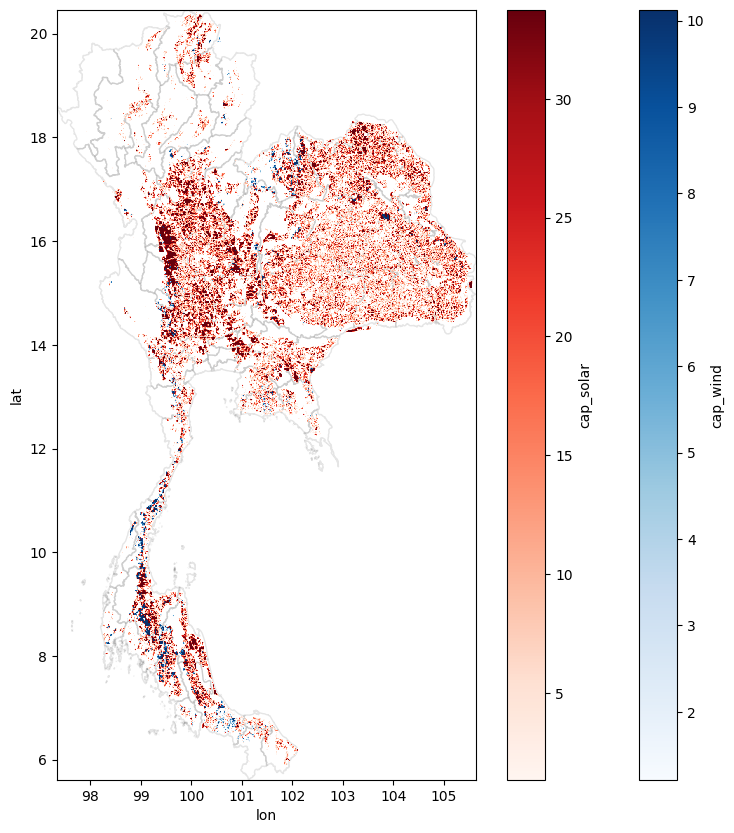

In [212]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

fig, ax = plt.subplots(figsize=(10,10))
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_ref['cap_wind'].where(xr_ref['cap_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_ref['cap_solar'].where(xr_ref['cap_solar']>0).plot(ax = ax,zorder = 2,cmap="Reds")


In [213]:
province = "Kalasin"
province = thailandmap.loc[thailandmap['ADM1_EN'] == province]
print(province.unary_union.bounds)
min_lon = province.unary_union.bounds[0]
max_lon = province.unary_union.bounds[2]
max_lat = province.unary_union.bounds[3]
min_lat = province.unary_union.bounds[1]

(103.09676066900005, 16.181673239000077, 104.24064016800008, 17.101957866000078)


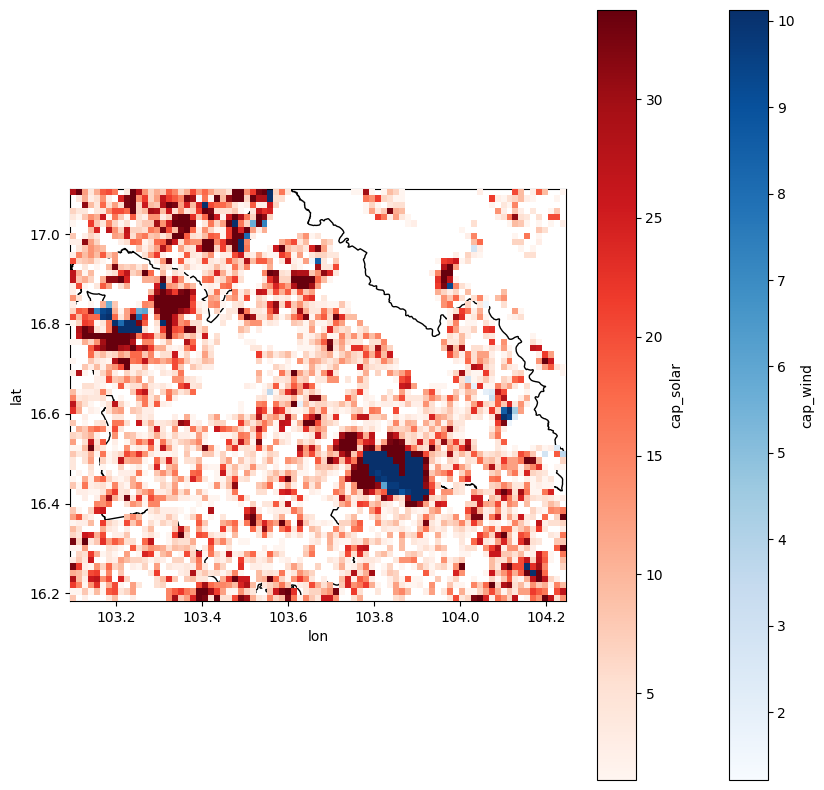

In [214]:
xr_buffer = xr_ref.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
# print(xr_buffer)

fig, ax = plt.subplots(figsize=(10,10))
province.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
xr_buffer['cap_wind'].where(xr_buffer['cap_wind']>0).plot(ax = ax,zorder = 1,cmap="Blues")
xr_buffer['cap_solar'].where(xr_buffer['cap_solar']>0).plot(ax = ax,zorder = 3,cmap="Reds")
